In [ ]:
!pip install -q -U transformers peft accelerate bitsandbytes datasets

In [ ]:
# import all the essential library
from datasets import load_dataset
import collections
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import pandas as pd
from google.colab import userdata
from huggingface_hub import login

In [ ]:
# Login to huggingface by using the access token
HF_TOKEN = userdata.get('hf_access')
login(token=HF_TOKEN)

In [ ]:
# Load and print sql dataset
dataset_name = "b-mc2/sql-create-context"
dataset = load_dataset(dataset_name, split="train")

print(dataset[:5])


{'answer': ['SELECT COUNT(*) FROM head WHERE age > 56', 'SELECT name, born_state, age FROM head ORDER BY age', 'SELECT creation, name, budget_in_billions FROM department', 'SELECT MAX(budget_in_billions), MIN(budget_in_billions) FROM department', 'SELECT AVG(num_employees) FROM department WHERE ranking BETWEEN 10 AND 15'], 'question': ['How many heads of the departments are older than 56 ?', 'List the name, born state and age of the heads of departments ordered by age.', 'List the creation year, name and budget of each department.', 'What are the maximum and minimum budget of the departments?', 'What is the average number of employees of the departments whose rank is between 10 and 15?'], 'context': ['CREATE TABLE head (age INTEGER)', 'CREATE TABLE head (name VARCHAR, born_state VARCHAR, age VARCHAR)', 'CREATE TABLE department (creation VARCHAR, name VARCHAR, budget_in_billions VARCHAR)', 'CREATE TABLE department (budget_in_billions INTEGER)', 'CREATE TABLE department (num_employees IN

In [ ]:
def create_prompt(example):
    # Define Prompt template
    prompt_template = """### INSTRUCTION:
You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given the CREATE TABLE statement for the database and a question. You must generate the corresponding SQL query.

### DATABASE SCHEMA:
{context}

### QUESTION:
{question}

### RESPONSE (SQL Query):
{answer}"""

    prompt = prompt_template.format(
        context=example['context'],
        question=example['question'],
        answer=example['answer']
    )


    return {"text": prompt}


formatted_dataset = dataset.map(create_prompt)

print(formatted_dataset[0]['text'])

### INSTRUCTION:
You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given the CREATE TABLE statement for the database and a question. You must generate the corresponding SQL query.

### DATABASE SCHEMA:
CREATE TABLE head (age INTEGER)

### QUESTION:
How many heads of the departments are older than 56 ?

### RESPONSE (SQL Query):
SELECT COUNT(*) FROM head WHERE age > 56


In [ ]:
print(formatted_dataset)

Dataset({
    features: ['answer', 'question', 'context', 'text'],
    num_rows: 78577
})


In [ ]:
# Get the token or input length
model_name = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def getTokenLength(example):
    return {"token_length": len(tokenizer.encode(example['text']))}

dataset_with_lengths = formatted_dataset.map(getTokenLength)

In [ ]:
# Summary  of token length
lengths_df = pd.DataFrame(dataset_with_lengths['token_length'], columns=['Token Length'])
print(lengths_df.describe())

       Token Length
count  78577.000000
mean     152.675885
std       21.116305
min      101.000000
25%      138.000000
50%      149.000000
75%      162.000000
max      594.000000


In [ ]:
sql_keywords = ["SELECT", "FROM", "WHERE", "GROUP BY", "ORDER BY", "LIMIT", "JOIN", "ON", "AS", "DISTINCT"]
keyword_counts = collections.defaultdict(int)


for query in dataset['answer']:

    query_upper = query.upper()
    for keyword in sql_keywords:
        if keyword in query_upper:
            keyword_counts[keyword] += 1

print("Frequency of SQL Keywords in Answers:")

for keyword, count in sorted(keyword_counts.items(), key=lambda item: item[1], reverse=True):
    print(f"{keyword}: {count}")

Frequency of SQL Keywords in Answers:
SELECT: 78577
FROM: 78577
WHERE: 75675
ON: 29014
AS: 11736
JOIN: 1931
GROUP BY: 1160
ORDER BY: 1062
LIMIT: 757
DISTINCT: 436


In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
MAX_LENGTH = 512
def tokenize_and_prepare_labels(example):
    # Take the complete format
    full_prompt = example['text']

    # Tokenize it. truncation=True mean if prompt is very large the remove or cut extra part
    tokenized_full_prompt = tokenizer(full_prompt, truncation=True, max_length=MAX_LENGTH, padding='max_length')

    # make a copy of input ids
    labels = tokenized_full_prompt['input_ids'].copy()

    user_prompt = f"""### INSTRUCTION:
You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given the CREATE TABLE statement for the database and a question. You must generate the corresponding SQL query.

### DATABASE SCHEMA:
{example['context']}

### QUESTION:
{example['question']}

### RESPONSE (SQL Query):
"""

    # Tokenize the input part
    tokenized_user_prompt = tokenizer(user_prompt, truncation=True, max_length=MAX_LENGTH, padding=False)

    # Find the length of input part
    user_prompt_len = len(tokenized_user_prompt['input_ids'])


    # mask the input part using -100 so that loss will be calculate using answer
    for i in range(user_prompt_len):
        labels[i] = -100

    # put label and input in final dictionary
    tokenized_full_prompt['labels'] = labels

    return tokenized_full_prompt

# Apply above function on complete dataset
tokenized_dataset = formatted_dataset.map(tokenize_and_prepare_labels, batched=False)

# Lets check an example
print(tokenized_dataset[0]['input_ids'])
print(tokenized_dataset[0]['labels'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [ ]:
# Model name
model_name = "mistralai/Mistral-7B-v0.1"

# Quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# Load the model in 4-bit
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    torch_dtype=torch.float16,
    device_map="auto",  # it will automatically put the model on GPU
    trust_remote_code=True,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Prepare the model for PEFT training
model = prepare_model_for_kbit_training(model)

# Make LoRA config
lora_config = LoraConfig(
    r=16, # Rank of the update matrices. Higher = more parameters, but might overfit. 16 is a good starting point.
    lora_alpha=32, # Alpha scaling factor. A good rule of thumb is alpha = 2 * r.
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], # where to add LoRA adapters inside the model's layer. This is standard for mistral.
    lora_dropout=0.05, # Dropout probability for LoRA layers to prevent overfitting.
    bias="none",
    task_type="CAUSAL_LM", # We are doing Causal Language Modeling (predicting the next token).
)

# Wrap the model with LoRA config
peft_model = get_peft_model(model, lora_config)

# Let's see the trainable parameters
peft_model.print_trainable_parameters()

trainable params: 13,631,488 || all params: 7,255,363,584 || trainable%: 0.1879


In [ ]:
training_args = TrainingArguments(
    output_dir="./sql-finetune-results",   # where to save results (checkpoints)
    num_train_epochs=1,  # Number of epochs. 1 is a good start for large datasets.
    per_device_train_batch_size=4, # how many examples will be given to GPU at a time
    gradient_accumulation_steps=1,
    optim="paged_adamw_8bit", # Memory-efficient optimizer
    learning_rate=2e-4, # How fast the model learns. 2e-4 is a good value for LoRA.
    lr_scheduler_type="cosine", # schedule to make learning rate low
    save_strategy="epoch", # save model after each epoch
    logging_steps=100, # Print loss on every 100 steps
    report_to="none", # We don't want to log to wandb or other services for now
)

In [ ]:
from transformers import  DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
# train_subset = tokenized_dataset.select(range(1000)) # uncomment this line if you want to use only 1000 examples else use data_collector
# Create a Trainer Object
trainer = Trainer(
    model=peft_model,  # Our trainable LoRA model
    train_dataset=train_subset, # Our tokenized dataset
    args=training_args, # Training arguments which we have define earlier
    data_collator=data_collator
)

# Let's gooooo!
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
100,0.384100
200,0.273800


TrainOutput(global_step=250, training_loss=0.3142960319519043, metrics={'train_runtime': 6942.8816, 'train_samples_per_second': 0.144, 'train_steps_per_second': 0.036, 'total_flos': 2.1885823746048e+16, 'train_loss': 0.3142960319519043, 'epoch': 1.0})

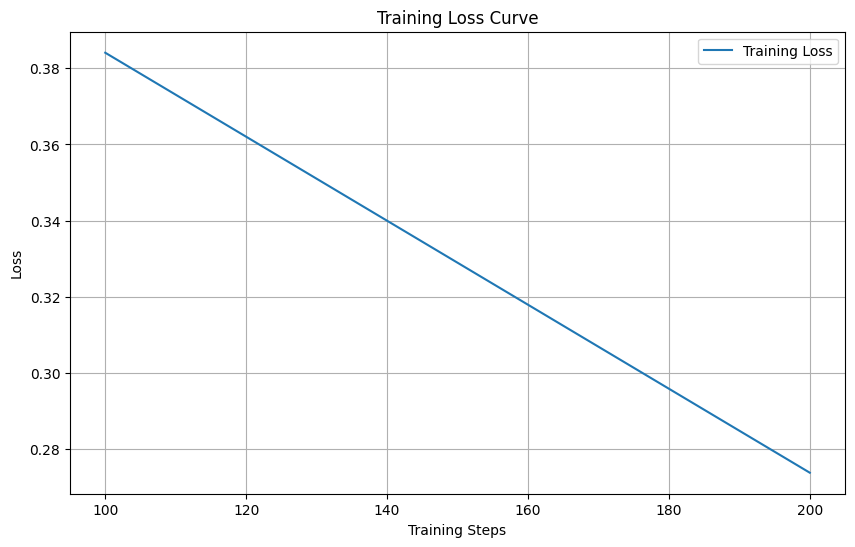

In [ ]:
import matplotlib.pyplot as plt


training_history = trainer.state.log_history

steps = [entry['step'] for entry in training_history if 'loss' in entry]
losses = [entry['loss'] for entry in training_history if 'loss' in entry]

plt.figure(figsize=(10, 6))
plt.plot(steps, losses, label="Training Loss")
plt.title("Training Loss Curve")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
output_dir = "mistral-7b-sql-finetuned"

peft_model.save_pretrained(output_dir) # save finetunned model

tokenizer.save_pretrained(output_dir) # Save Tokenizer

('mistral-7b-sql-finetuned/tokenizer_config.json',
 'mistral-7b-sql-finetuned/special_tokens_map.json',
 'mistral-7b-sql-finetuned/tokenizer.model',
 'mistral-7b-sql-finetuned/added_tokens.json',
 'mistral-7b-sql-finetuned/tokenizer.json')

In [ ]:
from transformers import pipeline
import torch

# Database schema (context) for a new question
test_context = """CREATE TABLE head (age INTEGER)"""

# Our new question
test_question = "How many heads of the departments are older than 56?"


# Use the same prompt template which was used in training but don't pass answer's part
prompt = f"""### INSTRUCTION:
You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given the CREATE TABLE statement for the database and a question. You must generate the corresponding SQL query.

### DATABASE SCHEMA:
{test_context}

### QUESTION:
{test_question}

### RESPONSE (SQL Query):
"""

# Using pipeline is the easy way to use text generateion
# peft_model is the model which we finetunned
text_gen_pipeline = pipeline(
    "text-generation",
    model=peft_model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
    device_map="auto"
)

# do_sample=True adds some randomness for better results
sequences = text_gen_pipeline(
    prompt,
    max_new_tokens=100,
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
)


full_response = sequences[0]['generated_text']
sql_query = full_response.split("### RESPONSE (SQL Query):")[1].strip()

print("---PROMPT---")
print(prompt)
print("\n---GENERATED SQL---")
print(sql_query)

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


---PROMPT---
### INSTRUCTION:
You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given the CREATE TABLE statement for the database and a question. You must generate the corresponding SQL query.

### DATABASE SCHEMA:
CREATE TABLE head (age INTEGER)

### QUESTION:
How many heads of the departments are older than 56?

### RESPONSE (SQL Query):


---GENERATED SQL---
SELECT COUNT(*) FROM head WHERE age > 56
